__Generation (Decoder)__ 
---

[![colab image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/astro-informatics/s2scat/blob/main/notebooks/auto_generation.ipynb)

This tutorial is a basic overview of how one may use the scattering covariances as a statistical generative model. 

Generative AI models typically require the abundance of realistic training data. In many (often high dimensional) application domains, such as the sciences, such training data does not exist, limiting generative AI approaches.

One may instead construct an expressive statistical representation from which, provided at least a single fiducial realisation, many realisations may be drawn. This concept is actually very familiar, particularly in cosmology where it is typical to draw Gaussian realisations from a known power spectrum.  However, this generative model does not capture complex non-linear structural information.

Here we will instead use the scattering covariances $\Phi(x)$ as our statistical representation. Given $\Phi$ is a non-linear function of the data $x$, generating new realisations isn't quite so straightforward.  In fact, to do so we'll need to minimise the loss function:

$$ \mathcal{L}(x) = ||\Phi(x) - \Phi(x_t)||^2_2$$

where $\Phi(x_t)$ are the target covariances computed from the signal we are aiming to emulate $x_t$. To solve this optimisation with gradient based methods we clearly need to be able to differentiate through $\Phi$ which is a complex function involving wavelet transforms, non-linearities, spherical harmonic and Wigner transforms. 

As ``S2SCAT`` is a ``JAX`` package, we can readily access these gradients, so lets see exactly how this works! 

## Import the package

Lets first import ``S2SCAT`` and some basic plotting functions. We'll also pick up ``pickle`` to load the targets which have been stored just to save you some time.

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

# Install a spherical plotting package.
!pip install cartopy &> /dev/null

# Install s2fft and data if running on google colab.
if IN_COLAB:
    !pip install s2scat &> /dev/null
    !mkdir data/

In [2]:
import jax
jax.config.update("jax_enable_x64", True)

from matplotlib import pyplot as plt 
import numpy as np 
import cartopy.crs as ccrs 
import s2scat, s2fft

gpu


## Configure the problem

Lets set up the target field we are aiming to emulate, and the hyperparameters of the scattering covariance representation we will work with.

In [3]:
L = 256                # Spherical harmonic bandlimit.
N = 3                  # Azimuthal bandlimit (directionality).
J_min = 2              # Minimum wavelet scale.
reality = True         # Input signal is real.
recursive = False      # Use the fully precompute transform.

# Lets load in the spherical field we wish to model
x_t = np.load('data/target_map_lss.npy')
xlm_t = s2fft.forward_jax(x_t, L, reality=reality)[:,L-1:]

## Build the generative model

We have included an easy to use function which will return the generative model as a callable function. This is done by calling the following function.

In [4]:
decoder = s2scat.build_decoder(xlm_t, L, N, J_min, reality, recursive)

## Decode some textures from the model

The decoder model function takes a JAX random key which is used to reliably generate random arrays from which to initialise the optimisation. It is also vectorised to allow multiple generations simultaneously. 

Here we draw 10 samples each time solving 200 adam iterations with a learning rate of 1e-3.

In [25]:
key = jax.random.PRNGKey(0)
xlm_new = decoder(key, 10, 200, 1e-3)

We've generated some new harmonic coefficients $x_{\ell m}$ so we now need to map these back to spherical images which we'll do in HEALPix sampling.

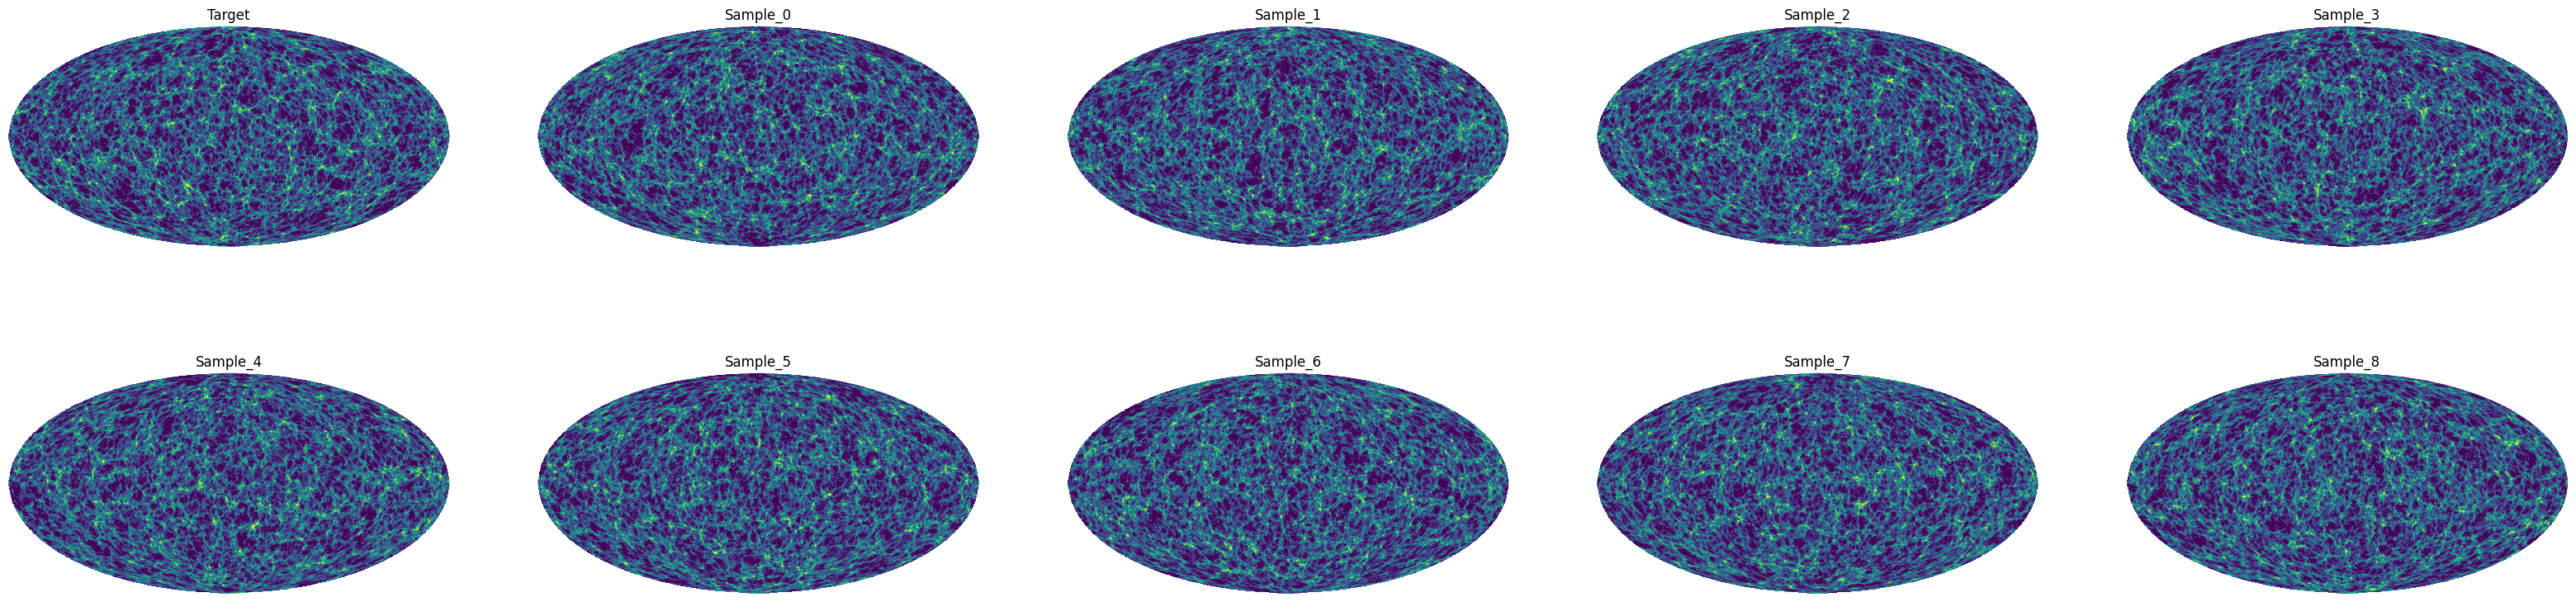

In [26]:
inverse_sht = jax.vmap(s2fft.inverse_jax, in_axes=(0,None))
x = inverse_sht(xlm_new, L)

fields = np.concatenate([x_t[None,:,:].real, x.real])
titles = ["Target"]
for i in range(10):
    titles.append(f"Sample_{i}")

fig, axs = plt.subplots(2, 5, subplot_kw={'projection': ccrs.Mollweide()}, figsize=(40,10))
mx, mn = 3, -1 

axs = axs.ravel()
for i in range(10):   
    axs[i].imshow(fields[i], transform=ccrs.PlateCarree(), cmap='viridis', vmax=mx, vmin=mn)
    axs[i].set_title(titles[i])
    axs[i].axis('off')
plt.show()